In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge

load data

In [2]:
rootpath = "data"
sub_id = "dy016"
samp_freq = 30_000

In [3]:
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, keep_active_trials=False, samp_freq=samp_freq)

In [4]:
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=False, samp_freq=samp_freq)

In [5]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [6]:
choices, stimuli, transformed_stimuli, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.769, right: 0.231
stimuli left: 0.507, right: 0.493
reward wrong: 0.231, correct: 0.769


visualize data

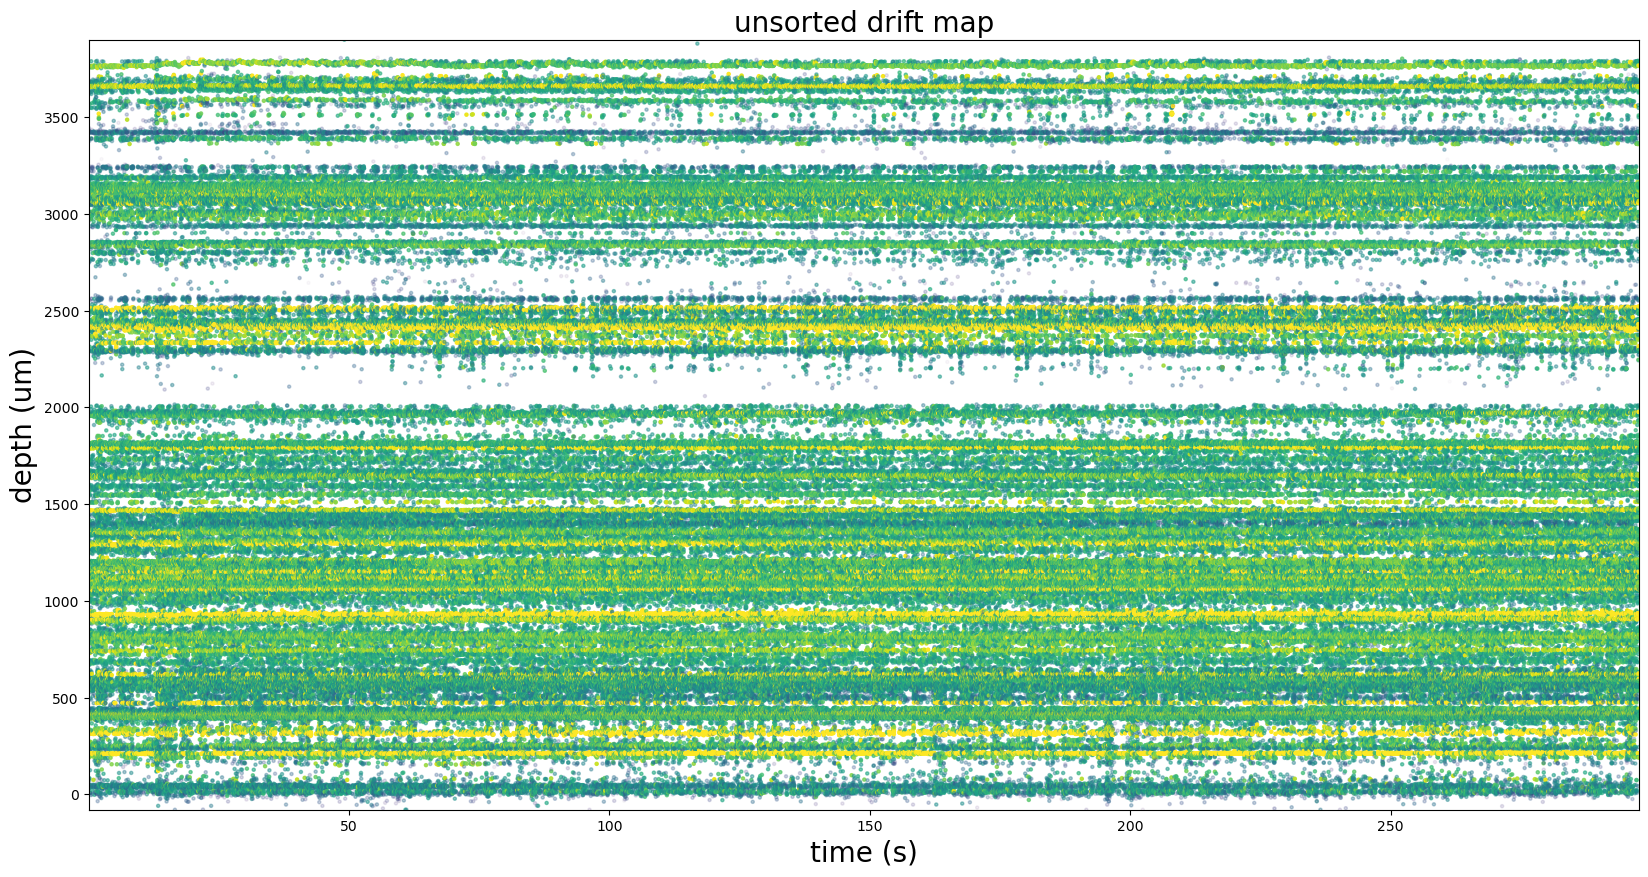

In [6]:
viz_tools.plot_drift_map(spikes_indices, spikes_features, n_spikes_display=500_000, samp_freq=samp_freq)

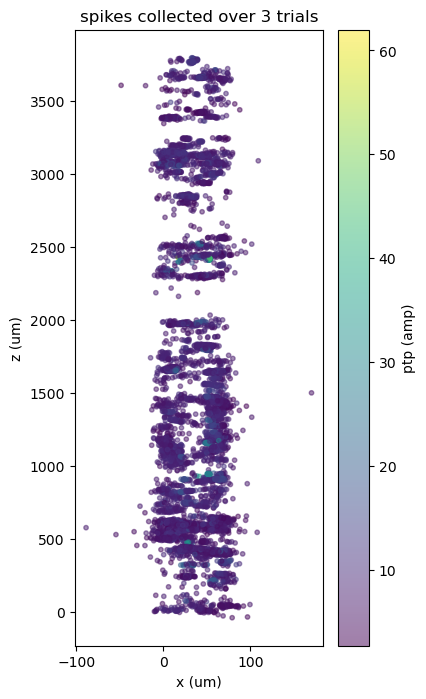

In [4]:
viz_tools.plot_spikes_features(trials, [1, 100, 200])

fit gmm

In [9]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [10]:
initial_gmm = init_gmm.initial_gaussian_mixtures('.', sub_id, trials, n_gaussians=300, seed=seed, fit_model=False)

In [11]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

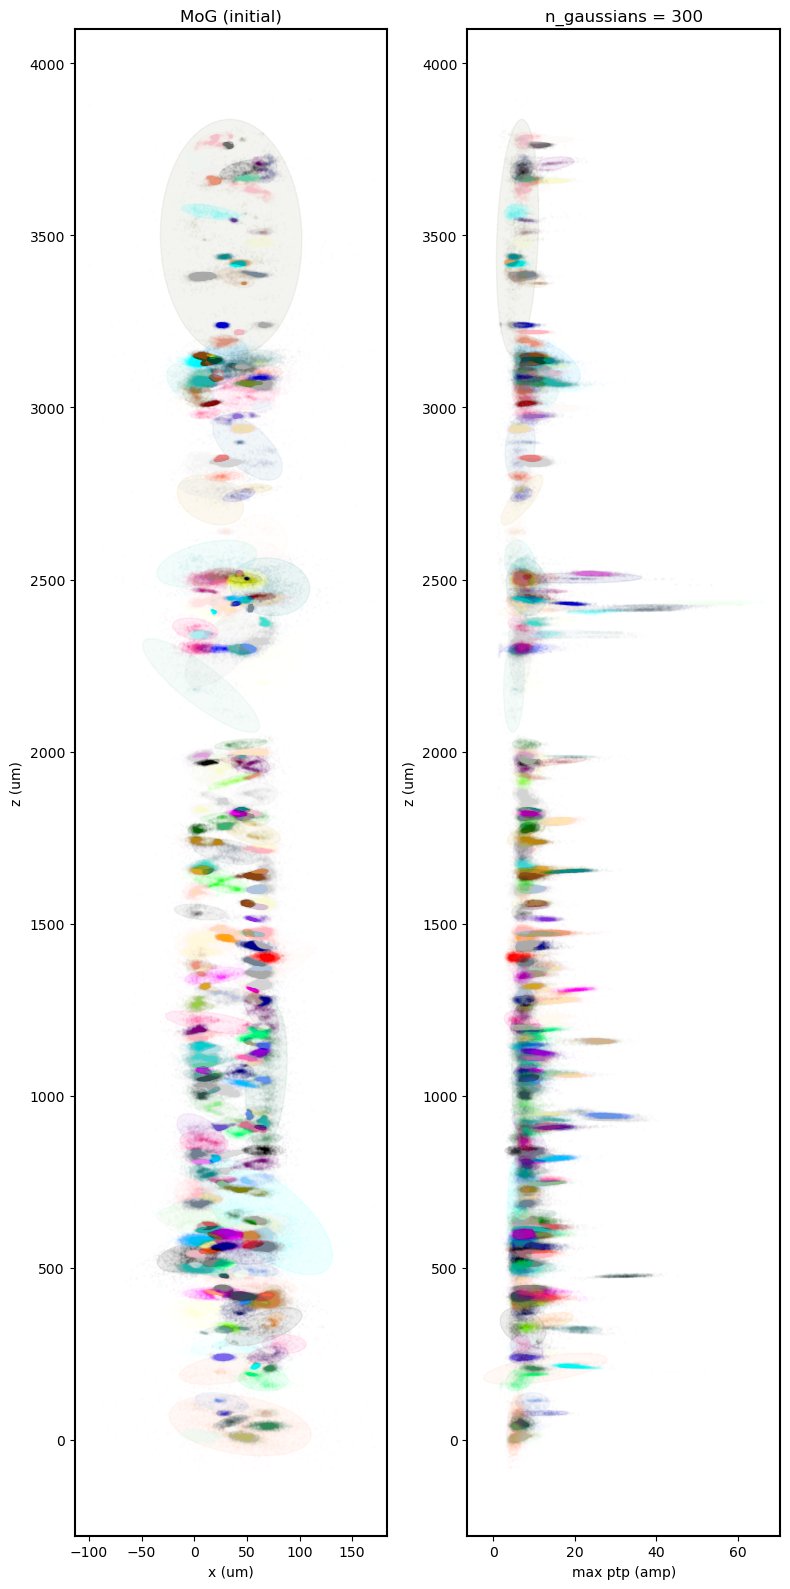

In [7]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, initial_labels, n_spikes_display=10_000)

split

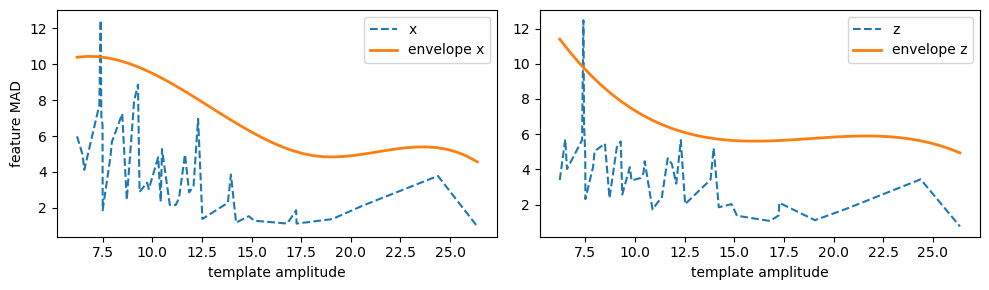

In [12]:
# plot smooth envelope for kilosort template feature MADs

split_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)

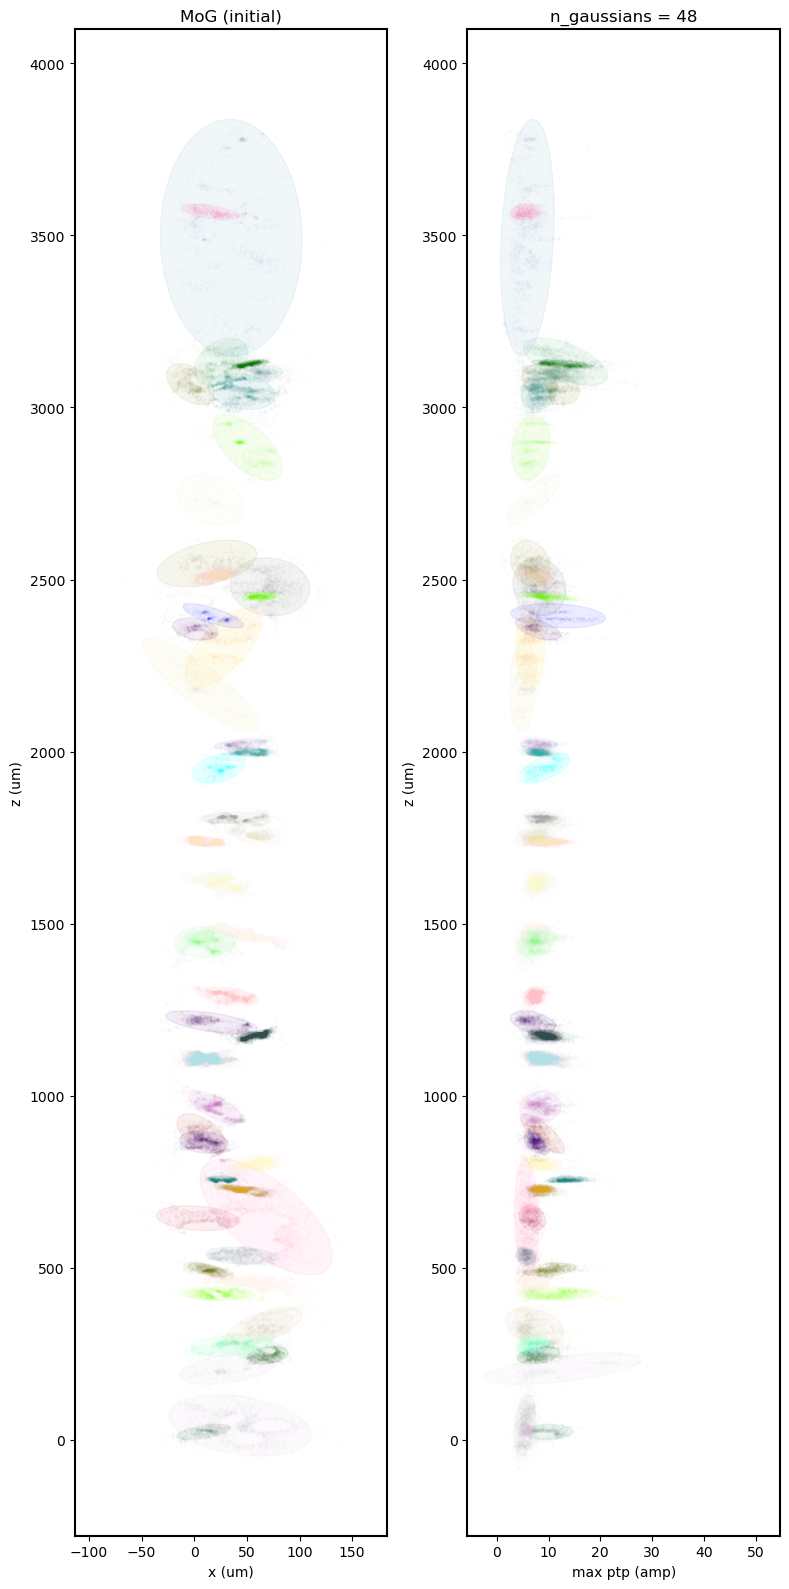

In [9]:
# plot gaussians to be split
viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, split_ids, n_spikes_display=10_000)

In [10]:
# post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, fit_model=True)

initial n_gaussians: 300 bic: 21822855.25
keep 252 gaussians and split 48 gaussians ...
pre-split bic: 22581426.94
split 7th gaussian into 2 gaussians with updated bic: 22520046.99
split 7th gaussian into 3 gaussians with updated bic: 22519856.82
split 7th gaussian into 4 gaussians with updated bic: 22519869.32
split 11th gaussian into 2 gaussians with updated bic: 22450643.09
split 11th gaussian into 3 gaussians with updated bic: 22466099.79
split 12th gaussian into 2 gaussians with updated bic: 22361184.21
split 12th gaussian into 3 gaussians with updated bic: 22369429.86
split 14th gaussian into 2 gaussians with updated bic: 22293679.62
split 14th gaussian into 3 gaussians with updated bic: 22297823.81
split 19th gaussian into 2 gaussians with updated bic: 22221087.74
split 19th gaussian into 3 gaussians with updated bic: 22225913.67
split 69th gaussian into 2 gaussians with updated bic: 22104820.66
split 69th gaussian into 3 gaussians with updated bic: 22107174.62
split 70th gaussi

In [13]:
post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, fit_model=False)
post_split_labels = post_split_gmm.predict(structured_unsorted)
post_split_probs = post_split_gmm.predict_proba(structured_unsorted)

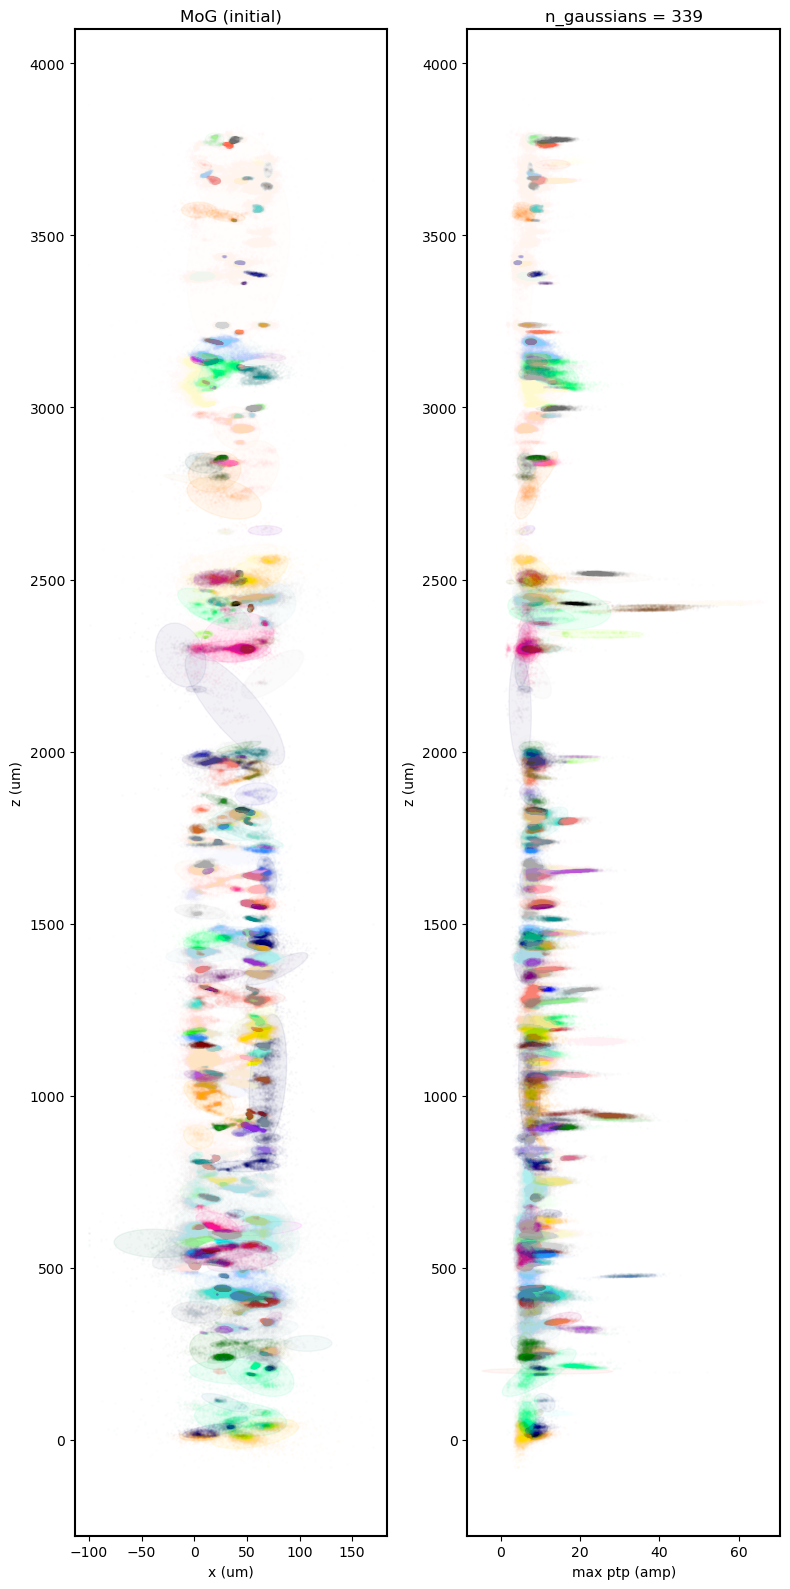

In [12]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_split_labels, post_split_labels, n_spikes_display=30_000)

merge

In [13]:
# corr_mat = split_merge.calc_corr_matrix(post_split_probs)
# np.save(f'pretrained/{sub_id}/corr_mat.npy', corr_mat)
corr_mat = np.load(f'pretrained/{sub_id}/corr_mat.npy')

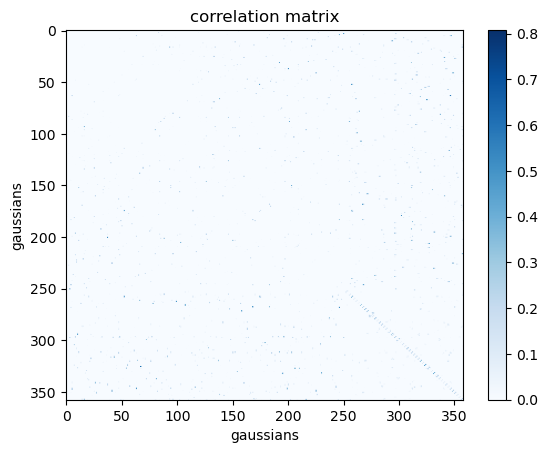

In [26]:
plt.imshow(corr_mat, cmap='Blues', aspect='auto')
plt.xlabel('gaussians')
plt.ylabel('gaussians')
plt.title('correlation matrix')
plt.colorbar();

In [67]:
merge_ids = split_merge.merge_criteria(corr_mat, 0.55)

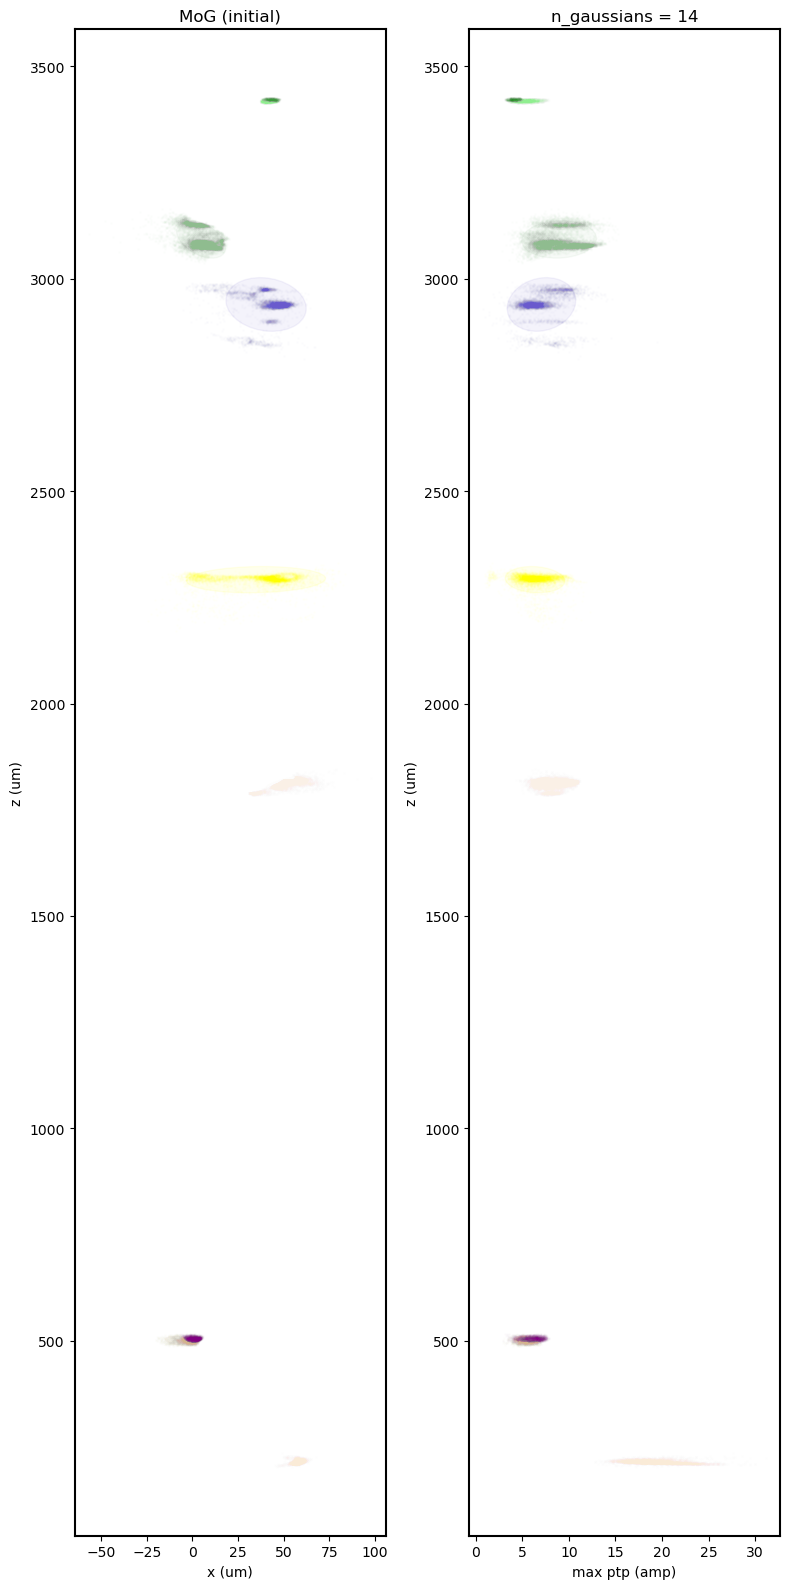

In [68]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_split_labels, np.unique(merge_ids), n_spikes_display=30_000)

In [71]:
post_merge_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm, post_split_labels, merge_ids, fit_model=True)

In [ ]:
post_merge_labels = post_merge_gmm.predict(structured_unsorted)
post_merge_probs = post_merge_gmm.predict_proba(structured_unsorted)

In [ ]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_merge_labels, post_merge_labels, n_spikes_display=30_000)

compute neural activity

In [11]:
sorted_neural_data = data_preprocess.compute_time_binned_neural_activity((ks_spikes_times, ks_spikes_clusters), 'sorted', stimulus_onset_times)
print(sorted_neural_data.shape)

(286, 514, 30)


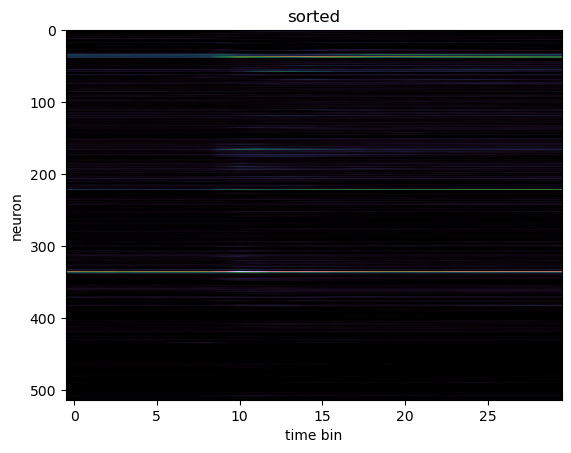

In [12]:
plt.imshow(sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('sorted');
plt.xlabel('time bin');
plt.ylabel('neuron');
plt.show()

In [7]:
unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(spikes_indices, 'unsorted', stimulus_onset_times)
print(unsorted_neural_data.shape)

(286, 384, 30)


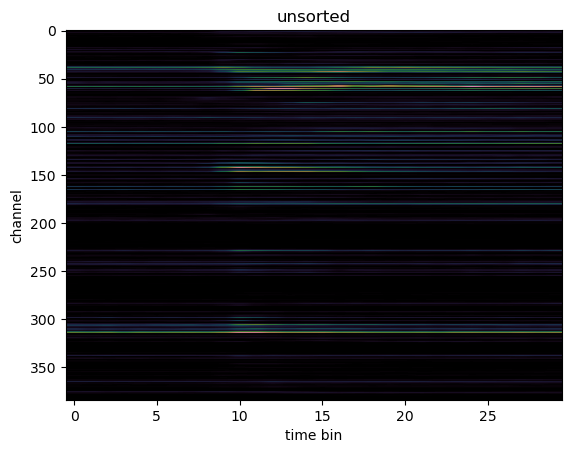

In [18]:
plt.imshow(unsorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('unsorted');
plt.xlabel('time bin');
plt.ylabel('channel');
plt.show()

In [17]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, post_split_labels, post_split_probs), 
                                            'clusterless', stimulus_onset_times)
print(clusterless_neural_data.shape)

(358, 30, 286)


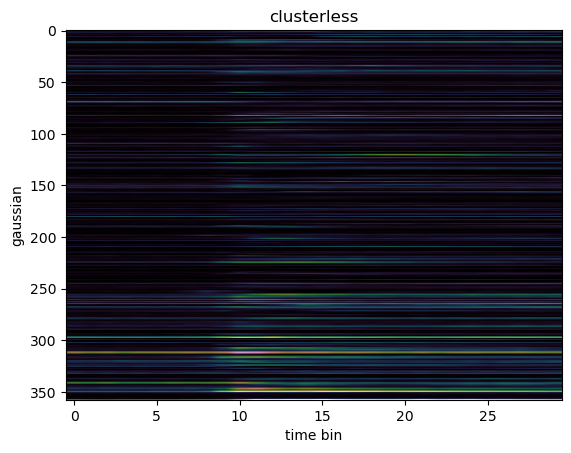

In [16]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless');
plt.xlabel('time bin');
plt.ylabel('gaussian');
plt.show()